# Exploring SNSF Public Data

## Foreword

The [Swiss National Science Foundation (SNSF)](http://www.snf.ch/en/Pages/default.aspx) is the leading public science funding agency in Switzerland.  In _GrantExport_, the SNSF provides detailed information about their approved grants.  In _PersonExport_, it also provides some information about the people associated to the grants.  Other tables provide further data about scientific publications, outputs, and collaborations reported by the grant applicants.  Please find the datasets and documentation [here](http://p3.snf.ch/Pages/DataAndDocumentation.aspx).

Prior to exploring the data, I performed a number of cleaning and tidying operations on the _GrantExport_ and _PersonExport_ datasets (see [cleaning.html](./cleaning.html)).

Below, we will look more closely at the data in _GrantExport_ and _PersonExport_ and try to get some insights especially on possible gender and funding allocation inequalities.

In [1]:
# boilerplate
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

# tidy datasets
grants=pd.read_feather('data/project.feather')
grantees=pd.read_feather('data/grantee.feather')
people=pd.read_feather('data/person.feather')

## Overview

In [2]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111903 entries, 0 to 111902
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   index           111903 non-null  int64   
 1   person_id_snsf  111903 non-null  int64   
 2   gender          111903 non-null  category
 3   first_name      111896 non-null  object  
 4   last_name       111903 non-null  object  
dtypes: category(1), int64(2), object(2)
memory usage: 3.5+ MB


In [3]:
grantees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255507 entries, 0 to 255506
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           255507 non-null  int64 
 1   person_id_snsf  255507 non-null  int64 
 2   role            255507 non-null  object
 3   project_number  255507 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ MB


In [4]:
assert any(grants.project_number.duplicated()) == False, 'project_number contains duplicated entries'
grants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74519 entries, 0 to 74518
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               74519 non-null  int64         
 1   project_number      74519 non-null  int64         
 2   programme           74479 non-null  category      
 3   funding_instrument  74519 non-null  category      
 4   domain              74020 non-null  category      
 5   topic               70748 non-null  category      
 6   discipline_name     74519 non-null  category      
 7   discipline_number   74519 non-null  int64         
 8   start_date          74517 non-null  datetime64[ns]
 9   end_date            74517 non-null  datetime64[ns]
 10  approved_amount     61387 non-null  float64       
dtypes: category(5), datetime64[ns](2), float64(1), int64(3)
memory usage: 3.9 MB


In [5]:
grants.start_date.min(), grants.end_date.max()

(Timestamp('1975-01-06 00:00:00'), Timestamp('2025-10-31 00:00:00'))

_GrantExport_ contains information about 74.5k approved grants, spanning across 50 years, from 1975 to 2025. Below, we check how many grants were approved on each year.

In [6]:
# remove 2 missing values for date
grants=grants.dropna(subset=['start_date'])
grants['year'] = grants['start_date'].dt.year


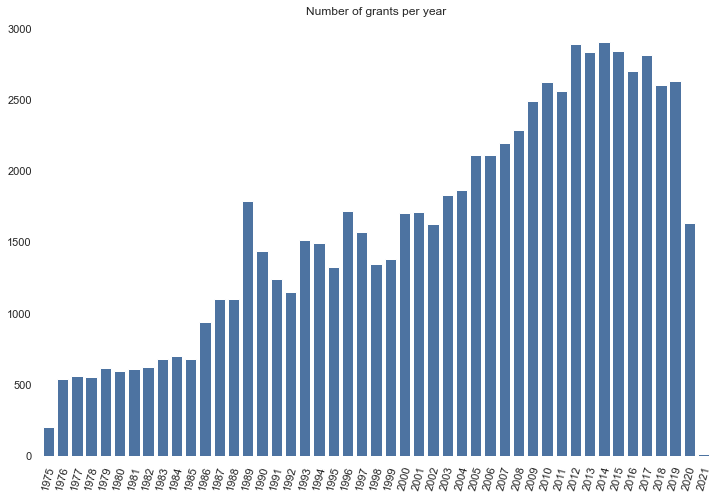

In [7]:
plt.box(on=None) 
sns.set_style("whitegrid")
g = sns.countplot(x='year', data=grants, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')
g.set_title('Number of grants per year')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center')
g;

From the 90's to 2010- onwards, the SNSF nearly duplicated the number of grants approved by year, reaching nearly 3000 grants per year.  Next we will check how does these numbers translate in terms of funding.

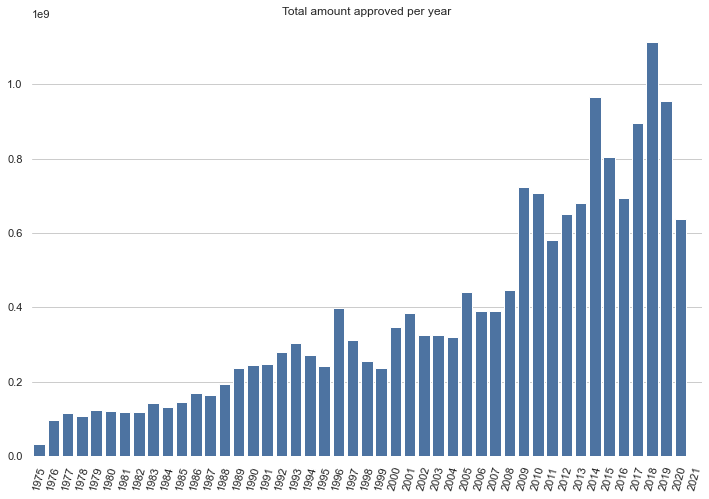

In [8]:
annual_funding = grants.groupby(['year'])['approved_amount'].sum().reset_index()
plt.box(on=None) 
sns.set_style("whitegrid")
g = sns.barplot(x='year', y='approved_amount', data=annual_funding, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')    
g.set_title('Total amount approved per year')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center', fontweight='light')
g;

In [9]:
annual_counts = grants.groupby(['year']).size().reset_index().rename(columns={0:'count'})
annual_stats = annual_counts.merge(annual_funding, on='year')
annual_stats = annual_stats.query('year < 2020')

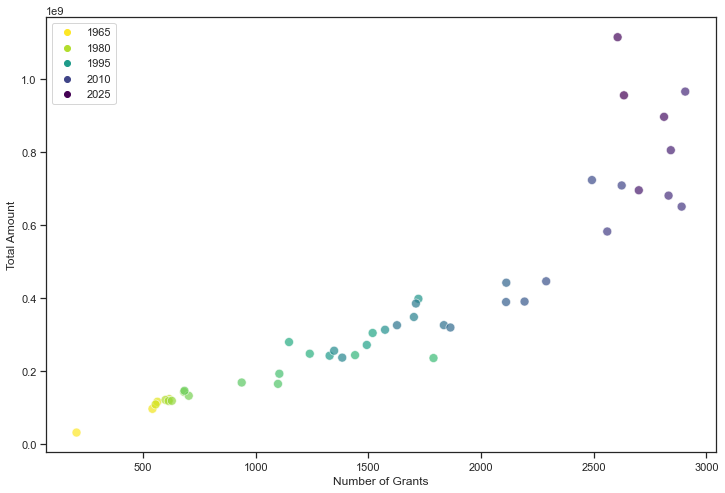

In [10]:
sns.set_style("ticks")
g = sns.scatterplot(x="count", y="approved_amount", hue=annual_stats.year.tolist(), palette='viridis_r', alpha=.7, s = 80, data=annual_stats)
g.set_xlabel('Number of Grants')
g.set_ylabel('Total Amount')  
g;

A scatterplot between the total amounts and the number of grants approved annually highlights a higher volatility in terms of annual amounts per number of grants in more recent years.

## Looking at `gender`

### Gender of project leaders

Let's redo the previous figures, adding the gender of project leaders (also known as principal investigators), grantees for which `role == 'responsible_applicant'`.


In [11]:
grantees.role.value_counts()

employee                 127500
responsible_applicant     73608
applicant                 46609
partner                    5961
contact_person             1033
practice_partner            796
Name: role, dtype: int64

In [12]:
# grants represented by their main applicants
pi = grantees.query('role == "responsible_applicant"').merge(grants, on='project_number')
# adding gender from people table
pi = pi.merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
pi = pi.drop(['index_x', 'index_y'], axis=1)

In [13]:
annual_counts = pi.groupby(['year', 'gender']).size().reset_index().rename(columns={0:'count'})
annual_funding = pi.groupby(['year', 'gender'])['approved_amount'].sum().reset_index()
annual_stats = annual_counts.merge(annual_funding, on=['year', 'gender'])
annual_stats = annual_stats.query('year < 2020')

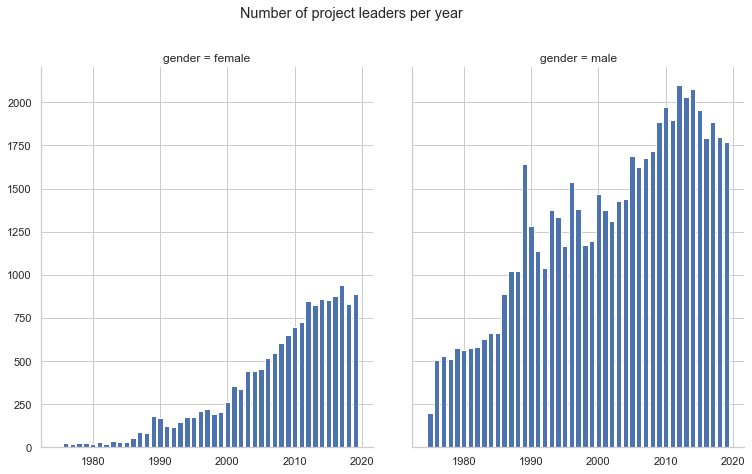

In [14]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project leaders per year')
g;

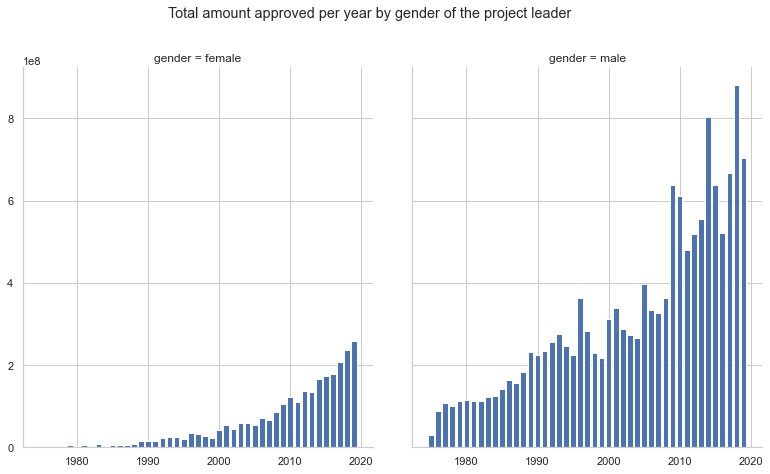

In [15]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'approved_amount')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Total amount approved per year by gender of the project leader')
g;

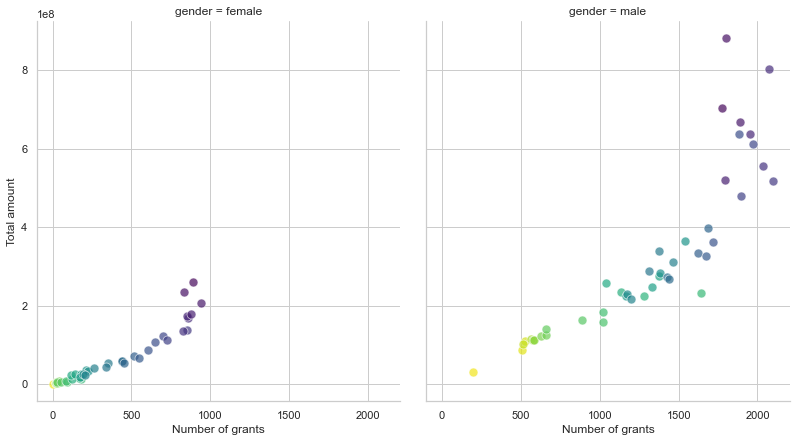

In [16]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', hue='year', palette='viridis_r', data=annual_stats)
g.map(sns.scatterplot, 'count', 'approved_amount', alpha=.7, s=80)
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels("Number of grants", "Total amount")
g;

### Gender of employees

In [17]:
workforce = grantees.query('role == "employee"').merge(grants, on='project_number')
workforce = workforce.merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
workforce = workforce.drop(['index_x', 'index_y'], axis=1)

In [18]:
annual_counts = workforce.groupby(['year', 'gender']).size().reset_index().rename(columns={0:'count'})
annual_counts = annual_counts.query('year < 2020')

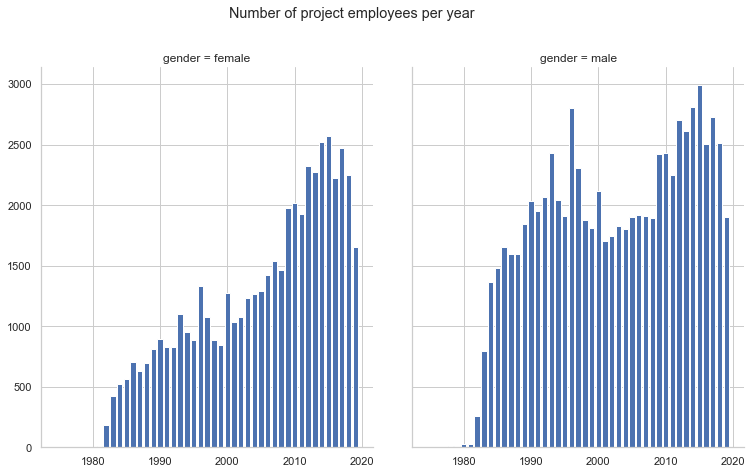

In [19]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_counts)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project employees per year')
g;

See also: [slides](./index.html) for insights, [cleaning.html](./cleaning.html) for wrangling steps